# Design Patterns

- Sequence
  * workflows
- Specialization / Generalization
  * student / faculty / staff
- Hierarchies
  * Ownership
  * Using composite primary keys
  * Secondary keys
- Parameterization
  * 
- Associations
  * Many-to-many relationships
  * Directed graphs 
  * Trees
  * Undirected graphs
- Master-part


In [26]:
import datajoint as dj

In [ ]:
schema = dj.schema('dimitri_patterns')

Proceed to delete entire schema `dimitri_patterns`? [yes, No]: yes


# Sequence / Workflows

In [28]:
# E.g. order / shipment / confirmation

In [29]:
@schema
class Order(dj.Manual):
    definition = """
    order_number : int
    ---
    order_date : date
    """

In [30]:
@schema
class Shipment(dj.Manual):
    definition = """
    -> Order
    ---
    ship_date : date
    """

In [31]:
@schema
class Confirm(dj.Manual):
    definition = """
    -> Shipment
    ---
    confirm_date : date
    """

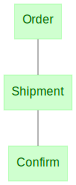

In [32]:
dj.Diagram(schema)

In [33]:
Order * Shipment * Confirm

order_number,order_date,ship_date,confirm_date


In [34]:
@schema
class Order2(dj.Manual):
    definition = """
    order_number : int
    ---
    order_date : date
    """
    
@schema
class Shipment2(dj.Manual):
    definition = """
    shipment_id : int
    ---
    ->[unique] Order2
    ship_date : date
    """
    
@schema
class Confirm2(dj.Manual):
    definition = """
    confirm_id : int
    ---
    -> [unique] Shipment2
    confirm_date : date
    """

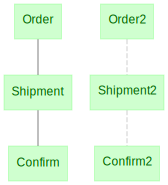

In [35]:
dj.Diagram(schema)

In [36]:
Order * Confirm

order_number,order_date,confirm_date


In [37]:
Order * Shipment * Confirm 

order_number,order_date,ship_date,confirm_date


# Two ways to model hierarchies

## Approach 1: Simple primary keys with secondary dependencies

In [38]:
@schema
class Subject(dj.Manual):
    definition = """
    # Experiment Subject
    subject_id : int
    ---
    species = 'mouse' : enum('human', 'mouse', 'rat', 'worm')
    sex : enum('F', 'M', 'unknown')
    """
    

In [39]:
Subject()

subject_id,species,sex


In [40]:
Subject.insert1(dict(subject_id=1, species="human", sex="unknown"), skip_duplicates=True)
Subject.insert1(dict(subject_id=2, species="mouse", sex="F"), skip_duplicates=True)
Subject.insert1(dict(subject_id=3, species="worm", sex="M"), skip_duplicates=True)

In [41]:
@schema
class Session(dj.Manual):
    definition = """
    -> Subject
    session : int
    ---
    session_timestamp = CURRENT_TIMESTAMP : timestamp
    """

In [42]:
Session.insert1(dict(session=1, subject_id=2), skip_duplicates=True)
Session.insert1(dict(session=2, subject_id=2), skip_duplicates=True)
Session.insert1(dict(session=3, subject_id=3), skip_duplicates=True)

In [43]:
Session()

subject_id,session,session_timestamp
2,1,2022-11-08 17:24:53
2,2,2022-11-08 17:24:53
3,3,2022-11-08 17:24:53


In [44]:
@schema
class Scan(dj.Manual):
    definition = """
    -> Session
    scan_id : int
    ---
    laser_power : float  # mW
    """

In [45]:
Scan()

subject_id,session,scan_id,laser_power mW


In [46]:
Scan.insert1(dict(subject_id=2, scan_id=1, session=1, laser_power=3200))

In [47]:
@schema
class Cell(dj.Manual):
    definition = """
    -> Scan
    cell_id : int
    ---
    cell_type : enum('E', 'I')   # excitatory or inhibitory
    """

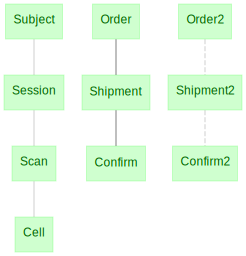

In [48]:
dj.Diagram(schema)

In [49]:
# Give me excitatory cells for all males

In [50]:
Cell & (Subject & {'sex': "M"})

subject_id,session,scan_id,cell_id,cell_type excitatory or inhibitory


In [51]:
@schema
class Subject2(dj.Manual):
    definition = """
    # Experiment Subject
    subject_id : int
    ---
    species = 'mouse' : enum('human', 'mouse', 'rat', 'worm')
    sex : enum('F', 'M', 'unknown')
    """

@schema
class Session2(dj.Manual):
    definition = """
    session : int
    ---
    -> Subject2
    session_timestamp = CURRENT_TIMESTAMP : timestamp
    """
    
@schema
class Scan2(dj.Manual):
    definition = """
    scan_id : int
    ---
    -> Session2
    laser_power : float  # mW
    """
    
@schema
class Cell2(dj.Manual):
    definition = """
    cell_id : int
    ---
    -> Scan2
    cell_type : enum('E', 'I')   # excitatory or inhibitory
    """

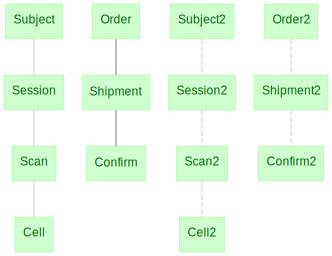

In [52]:
dj.Diagram(schema)

In [53]:
Cell.insert1(dict(cell_id=1, scan_id=1, cell_type="E"))

MissingAttributeError: Field 'subject_id' doesn't have a default value

In [ ]:
Cell()

In [ ]:
# Give me cells for subject_id=1

Cell2 & (Scan2 & (Session2 & 'subject_id=2'))

In [ ]:
# Give me cells for all males

(Cell2 & (Scan2 & (Session2 & (Subject2 & 'sex="M"')))).make_sql()

In [ ]:
(Cell & (Subject & 'sex="M"')).make_sql()

In [ ]:
dj.Diagram(schema)

# Parameterization

In [ ]:
@schema
class Image(dj.Manual):
    definition = """
    image_id : int
    ---
    image : longblob
    """

In [ ]:
@schema
class EnhanceMethod(dj.Lookup):
    definition = """
    enhance_method : int
    ---
    method_name : varchar(16)
    """
    
    contents = ((1, "sharpen"), (2, "contrast"))

In [ ]:
@schema
class EnhancedImage(dj.Manual):
    definition = """
    -> Image
    -> EnhanceMethod
    ---
    enhanced_image : longblob
    """

In [ ]:
dj.Diagram(schema)

# Association 

Books and authors

Checking accounts and account owners

In [54]:
@schema
class Book(dj.Manual):
    definition = """
    isbn : int
    ---
    title : varchar(300)
    """

In [55]:
@schema
class Author(dj.Manual):
    definition = """
    author_id : int
    ---
    name : varchar(300)
    """

In [56]:
@schema
class AuthorBook(dj.Manual):
    definition = """
    -> Author
    -> Book
    ---
    order : tinyint unsigned 
    unique index(isbn, order)
    """

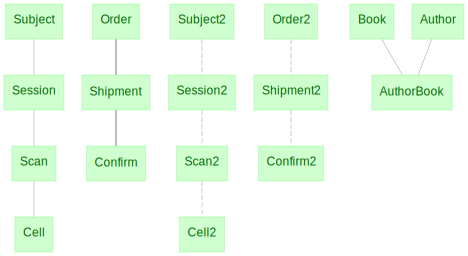

In [57]:
dj.Diagram(schema)

# Generalization / specialization

Employee, student, instructor

In [58]:
@schema
class Person(dj.Manual):
    definition = """
    person_id : int
    ---
    date_of_birth : date
    gender : enum("male", "female", "unknown")
    """

In [59]:
@schema
class Employee(dj.Manual):
    definition = """
    -> Person
    ---
    hire_date : date    
    """
    
@schema
class Instructor(dj.Manual):
    definition = """
    -> Employee
    ---
    department : varchar(30)
    """
    
@schema
class Student(dj.Manual):
    definition = """
    -> Person
    ---
    admission_date : date
    """

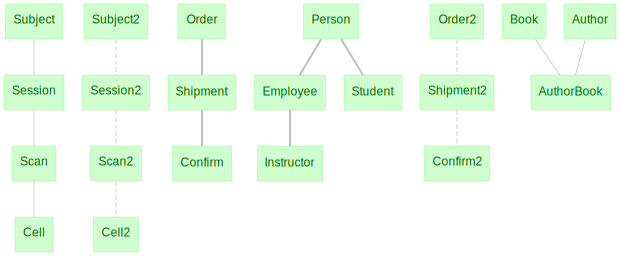

In [60]:
dj.Diagram(schema)

# Directed graphs 

In [61]:
@schema
class Subordinate(dj.Manual):
    definition = """
    -> Employee
    ---
    -> Employee.proj(manager_id="person_id")
    """

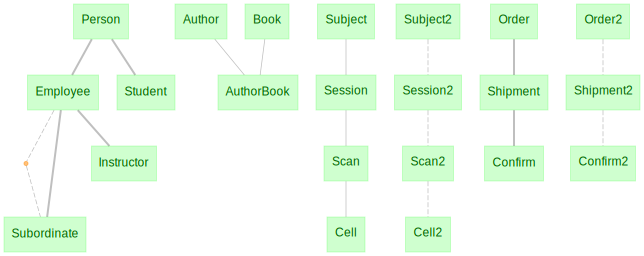

In [62]:
dj.Diagram(schema)

In [63]:
@schema
class Neuron(dj.Manual):
    definition = """
    neuron : int
    """
    
@schema
class Synapse(dj.Manual):
    definition = """
    synapse_id : int
    ---
    -> Neuron.proj(pre="neuron")
    -> Neuron.proj(post="neuron")    
    """

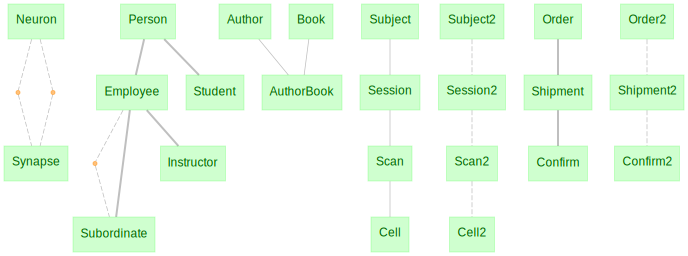

In [64]:
dj.Diagram(schema)

```sql

CREATE TABLE managed_by (
   person_id : int NOT NULL,
   manager_id : int NOT NULL,
   
   PRIMARY KEY (person_id),
   
   FOREIGN KEY (person_id) REFERENCES employee (person_id),
   FOREIGN KEY (manager_id) reference employee (person_id))
   

# Undirected graphs

In [65]:
# direcated friendship = full directed graph capability
@schema
class Friendship(dj.Manual):
    definition = """
    -> Person.proj(friend1 = "person_id")
    -> Person.proj(friend2 = "person_id")
    """

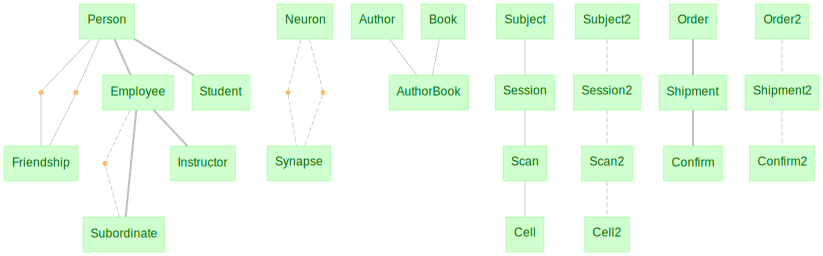

In [66]:
dj.Diagram(schema)

In [67]:
@schema
class Order(dj.Manual):
    definition = """
    order_id : int
    ---
    order_date : date
    """
    
    class Item(dj.Part):
        definition = """
        -> master
        order_item : int
        ---
        
        """

# Puzzle: 
Cities and states.
1. Each city belongs to one state. 
2. Each state has one capital.
3. A capital is a city.
4. A capital must be in the same state. 

* Tables
* Primary keys
* Foreign keys

In [68]:
@schema
class State(dj.Manual):
    definition = """
    st : char(2)
    ---
    state : varchar(30)
    """

State.insert((
    ("WA", "Washington"),
    ("TX", "Texas"),
    ("AK", "Alaska"),
    ("LA", "Louisiana")
))

In [69]:
@schema
class City(dj.Manual):
    definition = """
    -> State
    city_name : varchar(30)
    ---
    capital = null : enum("YES")
    unique index(st, capital)
    """

In [70]:
City.delete_quick()

City.insert1(("WA", "Seattle", None))
City.insert1(("TX", "Austin", "YES"))
City.insert1(("TX", "Houston", None))
City.insert1(("WA", "Olympia", "YES"))


In [71]:
City()

st,city_name,capital
TX,Houston,None
TX,Austin,YES
WA,Seattle,None
WA,Olympia,YES


In [72]:
@schema
class State2(dj.Manual):
    definition = """
    state : char (2)
    ---
    state_name : varchar(30)
    """
    
@schema
class City2(dj.Manual):
    definition = """
    -> State2
    city_name : varchar(30)
    """
    
@schema
class Capital2(dj.Manual):
    definition = """
    -> State2
    ---
    -> City2
    """

In [73]:
State2.delete_quick()
City2.delete_quick()

State2.insert((
    ("WA", "Washington"),
    ("TX", "Texas"),
    ("AK", "Alaska"),
    ("LA", "Louisiana")
))

City2.insert1(("WA", "Seattle"))
City2.insert1(("TX", "Austin"))
City2.insert1(("TX", "Houston"))
City2.insert1(("WA", "Olympia"))

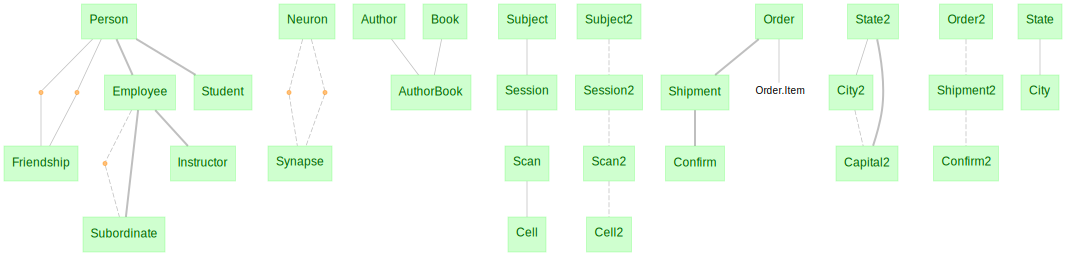

In [74]:
dj.Diagram(schema)

In [75]:
Capital2.insert1(("TX", "Austin"))

In [76]:
Capital2.insert1(("TX", "Houston"))

DuplicateError: ("Duplicate entry 'TX' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

In [77]:
City2()

state,city_name
TX,Austin
TX,Houston
WA,Olympia
WA,Seattle


# In SQL 

```sql
CREATE TABLE state (
    state char(2) NOT NULL,
    state_name varchar(30) NOT NULL,
    PRIMARY KEY (state))
    
CREATE TABLE city (
    state char(2) NOT NULL,
    city_name varchar(30) NOT NULL,
    PRIMARY KEY (state, city_name),
    FOREIGN KEY (state) REFERENCES state(state))

CREATE TABLE capital (
    state char(2) NOT NULL,
    city_name varchar(30) NOT NULL,
    PRIMARY KEY (state),
    FOREIGN KEY (state, city_name) REFERENCES city (state, city_name))
```


In [78]:

```sql
CREATE TABLE state (
    state char(2),
    state_name varchar(30),
    capital varchar(30),
    PRIMARY KEY (state),
    FOREIGN KEY (state, capital) REFERENCES city (state, city_name))
    
CREATE TABLE city (
    state char(2),
    city_name varchar(30),
    PRIMARY KEY (state, city_name))
    FOREIGN KEY (state) REFERENCES state(state)
```

SyntaxError: invalid syntax (724225854.py, line 1)

# In SQL 

```sql
CREATE TABLE state (
    state char(2) NOT NULL,
    state_name varchar(30) NOT NULL,
    PRIMARY KEY (state))
    
CREATE TABLE city (
    city_id int NOT NULL,
    state char(2) NOT NULL,
    city_name varchar(30) NOT NULL,
    is_capital enum('yes'),
    PRIMARY KEY (state_id),
    UNIQUE INDEX(state, is_capital),
    FOREIGN KEY (state) REFERENCES state(state))
```



## Problem 

Model a vet clinic. 

1. Customers bring in pets. Customers are identified by their cell phones. 

2. Pets are identified by their nicknames for that customer.

3. Pets have a date of birth, species, and date of birth.

4. Pets have a list of vaccinations that must be performed for their species.

5. Pets have vaccination administration, shot date. 

In [90]:
schema = dj.Schema('vet')

Proceed to delete entire schema `shared_vet`? [yes, No]: yes


In [91]:
@schema
class Owner(dj.Manual):
    definition = """
    cell_phone : char(10) 
    ---
    full_name : varchar(16)
    """

In [92]:
@schema
class Species(dj.Lookup):
    definition = """
    species : varchar(30)
    """
    contents = (('cat',), ('dog',), ('ferret',), ('parrot',))

In [93]:
Species()

species
cat
dog
ferret
parrot


In [94]:
@schema
class Pet(dj.Manual):
    definition = """
    -> Owner
    -> Species
    nickname : varchar(30)
    ---
    birthdate : date
    """

In [95]:
@schema
class RequiredVaccine(dj.Manual):
    definition = """
    -> Species
    vaccine  : varchar(10)
    """

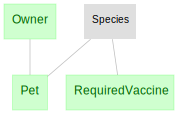

In [96]:
dj.Diagram(schema)

In [97]:
@schema
class Shot(dj.Manual):
    definition = """
    -> Pet
    -> RequiredVaccine
    ---
    shot_date : date
    """

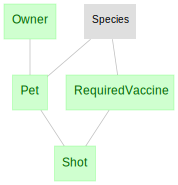

In [98]:
dj.Diagram(schema)

In [99]:
Shot()

cell_phone,species,nickname,vaccine,shot_date


```sql
create table shot (
    cell_phone char(10) NOT NULL,
    nickname varchar(16) NOT NULL,
    species varchar(20) NOT NULL,
    vaccine varchar(10) NOT NULL,
    PRIMARY KEY (cell_phone, nickname, species, vaccine),
    FOREIGN KEY (cell_phone, nickname, species) REFERENCES                         pet(cell_phone, nickname, species),
    FOREIGN KEY (species, vaccine) REFERENCES required_vaccine(species, vaccine)
)
```

## Homework homework

Homework assignments, students, grades

1. Homework is given with a due date.
2. Students submit homework, we record the submit date
3. Submitted homework gets a grade


In [100]:
@schema
class Assignment(dj.Manual):
    definition = """
    assignment : int
    ---
    due_date : date
    """

In [101]:
@schema 
class Student(dj.Manual):
    definition = """
    student_id : int
    ---
    student_name : varchar(30)
    """

In [102]:
@schema
class Submission(dj.Manual):
    definition = """
    -> Student
    -> Assignment
    ---
    submit_date : date
    """

In [103]:
@schema
class Grade(dj.Manual):
    definition = """
    -> Submission
    ---
    grade : char(1)
    """

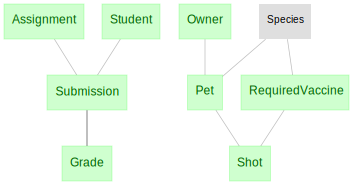

In [104]:
dj.Diagram(schema)

# Messaging App (Slack, Telegram, Signal)

1. Users can create channels. Each channel belongs to one user.
3. Channel names are globally unique
2. A user can create a post in their channels only
3. A user can be a guest in another person's channel.
4. Guest can reply to posts





In [105]:
@schema
class User(dj.Manual):
    definition = """
    username : varchar(12)
    ---
    irl_name : varchar(30)
    """

In [106]:
@schema
class Channel(dj.Manual):
    definition = """
    channel : varchar(12)
    ---
    -> User
    """

In [107]:
@schema
class Guest(dj.Manual):
    definition = """
    -> Channel
    -> User
    """

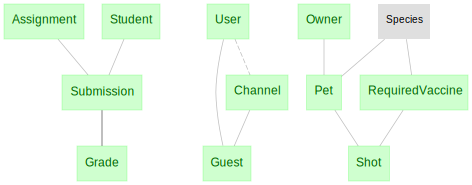

In [108]:
dj.Diagram(schema)

In [109]:
@schema
class Post(dj.Manual):
    definition = """
    -> Channel
    post : int
    ---
    message : varchar(1024)
    """

In [110]:
Post * Channel

channel,post,message,username


In [111]:
@schema
class Response(dj.Manual):
    definition = """
    -> Post
    -> Guest
    ---
    response : varchar(1024)
    """

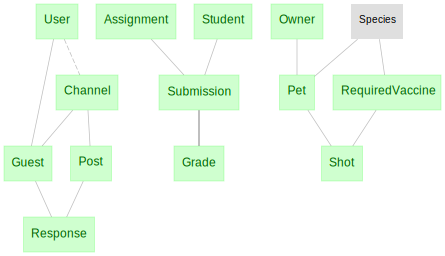

In [112]:
dj.Diagram(schema)